# Challenge: Optimization on Other Datasets

## Download data from `yfinance`

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

ticker = 'ZM'
df = yf.download(ticker)
df.index = pd.to_datetime(df.index)
df = df.droplevel('Ticker', axis=1)
df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-04-18,62.000000,62.000000,66.000000,60.320999,65.000000,25764700
2019-04-22,65.699997,65.699997,68.900002,59.939999,61.000000,9949700
2019-04-23,69.000000,69.000000,74.168999,65.550003,66.870003,6786500
2019-04-24,63.200001,63.200001,71.500000,63.160000,71.400002,4973500
2019-04-25,65.000000,65.000000,66.849998,62.599998,64.739998,3863300
...,...,...,...,...,...,...
2024-11-20,78.860001,78.860001,79.239998,77.879997,77.879997,2318000
2024-11-21,81.199997,81.199997,81.650002,78.900002,78.959999,3962000
2024-11-22,85.879997,85.879997,86.000000,81.400002,81.400002,5636100


## Preprocess the data

### Filter the date range

- Since 1 year ago at least

In [2]:
df = df.loc['2020-01-01':].copy()
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,68.720001,68.720001,69.235001,68.019997,68.800003,1315500
2020-01-03,67.279999,67.279999,68.680000,67.099998,67.620003,1127900
2020-01-06,70.320000,70.320000,70.495003,65.811996,66.629997,3151600
2020-01-07,71.900002,71.900002,72.838997,69.370003,70.290001,6985400
2020-01-08,72.550003,72.550003,73.290001,71.029999,71.809998,2482300
...,...,...,...,...,...,...
2024-11-20,78.860001,78.860001,79.239998,77.879997,77.879997,2318000
2024-11-21,81.199997,81.199997,81.650002,78.900002,78.959999,3962000
2024-11-22,85.879997,85.879997,86.000000,81.400002,81.400002,5636100


### Create the target variable

#### Percentage change

- Percentage change on `Adj Close` for tomorrow

In [3]:
df['change_tomorrow'] = df['Adj Close'].pct_change(-1)
df.change_tomorrow = df.change_tomorrow * -1
df.change_tomorrow = df.change_tomorrow * 100

#### Remove rows with any missing data

In [4]:
df = df.dropna().copy()
df

Price,Adj Close,Close,High,Low,Open,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,68.720001,68.720001,69.235001,68.019997,68.800003,1315500,-2.140313
2020-01-03,67.279999,67.279999,68.680000,67.099998,67.620003,1127900,4.323096
2020-01-06,70.320000,70.320000,70.495003,65.811996,66.629997,3151600,2.197499
2020-01-07,71.900002,71.900002,72.838997,69.370003,70.290001,6985400,0.895936
2020-01-08,72.550003,72.550003,73.290001,71.029999,71.809998,2482300,0.096392
...,...,...,...,...,...,...,...
2024-11-19,77.750000,77.750000,79.029999,77.495003,78.820000,4138400,1.407558
2024-11-20,78.860001,78.860001,79.239998,77.879997,77.879997,2318000,2.881769
2024-11-21,81.199997,81.199997,81.650002,78.900002,78.959999,3962000,5.449465


## Compute Machine Learning model

Proposal: Random Forest within `ensemble` module of `sklearn` library

In [5]:
from sklearn.ensemble import RandomForestRegressor


In [6]:
model_rf = RandomForestRegressor(max_depth=25)
X = df[['Open','High','Low','Close','Volume','Adj Close']]
y = df["change_tomorrow"]


## Parametrize & optimize the investment strategy

In [7]:
model_rf.fit(X, y)

RandomForestRegressor(max_depth=25)

### Create Strategy class

In [8]:
predict = model_rf.predict(X)
se = (predict-y).apply(lambda x: x*x)
mse = se.mean()
rmse = np.sqrt(mse)
print(f"{mse} / {rmse}")


2.3540889997759806 / 1.534304076699264


In [9]:
from backtesting import Backtest, Strategy

In [10]:
class SimpleRegression(Strategy):
    limit_buy = 1
    limit_sell = -5
    divider = 10
    
    def init(self):
        self.model = model_rf
        self.already_bought = False
        print(f"buy above {self.limit_buy} , sell under{self.limit_sell}")

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)
        
        if forecast_tomorrow > self.limit_buy/self.divider and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell/self.divider and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

In [11]:
model_rf.score(X,y)

0.815762442853524

### Create `Backtest` class

In [12]:
bt = Backtest(X, SimpleRegression, cash=10000,  commission=.002, exclusive_orders=True)



### Optimize backtesting with multiple combinations

In [13]:
import multiprocessing as mp
try:
  mp.set_start_method('fork')
except:
  pass

### Which are the best values for the parameters?

In [14]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0,8],
    limit_sell=[-8,0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True
    )

buy above 1 , sell under-5
buy above 4 , sell under0
buy above 2 , sell under-2
buy above 3 , sell under-8
buy above 6 , sell under-4
buy above 5 , sell under-7
buy above 2 , sell under-6
buy above 3 , sell under-1
buy above 6 , sell under-2
buy above 1 , sell under-5
buy above 6 , sell under-7
buy above 1 , sell under-4
buy above 3 , sell under-2
buy above 8 , sell under-5
buy above 4 , sell under-1
buy above 7 , sell under-5
buy above 3 , sell under-3
buy above 2 , sell under-5
buy above 5 , sell under0
buy above 1 , sell under-1
buy above 7 , sell under-6
buy above 8 , sell under-2
buy above 1 , sell under-3
buy above 6 , sell under-6
buy above 7 , sell under-7
buy above 4 , sell under-4
buy above 0 , sell under-7
buy above 0 , sell under-8
buy above 1 , sell under-8
buy above 1 , sell under-7
buy above 0 , sell under-4


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -4] before, using random point [8, 0]
  warnings.warn(


buy above 8 , sell under0


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -4] before, using random point [8, -1]
  warnings.warn(


buy above 8 , sell under-1


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -4] before, using random point [1, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -4] before, using random point [6, -5]
  warnings.warn(


buy above 6 , sell under-5


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -4] before, using random point [1, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -4] before, using random point [0, -3]
  warnings.warn(


buy above 0 , sell under-3
buy above 0 , sell under-5
buy above 0 , sell under-6


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -6] before, using random point [5, 0]
  warnings.warn(


buy above 0 , sell under0


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, -4]
  warnings.warn(


buy above 2 , sell under-4


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -3]
  warnings.warn(


buy above 6 , sell under-3


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -3] before, using random point [0, -1]
  warnings.warn(


buy above 0 , sell under-1


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [5, -3]
  warnings.warn(


buy above 5 , sell under-3


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [4, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [0, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -3]
  warnings.warn(


buy above 8 , sell under-3


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [4, -7]
  warnings.warn(


buy above 4 , sell under-7


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -2]
  warnings.warn(


buy above 7 , sell under-2


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [5, -1]
  warnings.warn(


buy above 5 , sell under-1


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [0, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [0, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [8, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The ob

buy above 8 , sell under-7


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, 0]
  warnings.warn(


buy above 2 , sell under0


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [4, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [5, -2]
  warnings.warn(


buy above 5 , sell under-2


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -4]
  warnings.warn(


buy above 3 , sell under-4


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [0, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [0, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, -8]
  warnings.warn(


buy above 2 , sell under-8


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -6]
  warnings.warn(


buy above 3 , sell under-6


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [6, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [1, -2]
  warnings.warn(


buy above 1 , sell under-2


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [4, -5]
  warnings.warn(


buy above 4 , sell under-5


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [8, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [0, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [3, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The

buy above 7 , sell under0


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [8, -8]
  warnings.warn(


buy above 8 , sell under-8


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [0, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [6, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The o

buy above 5 , sell under-4


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [3, 0]
  warnings.warn(


buy above 3 , sell under0


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [6, -1]
  warnings.warn(


buy above 6 , sell under-1


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -8]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, -7]
  warnings.warn(


buy above 2 , sell under-7


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, 0]
  warnings.warn(


buy above 6 , sell under0


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [0, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [3, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The 

buy above 4 , sell under-2


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [4, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [1, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [1, -6]
  warnings.warn(


buy above 1 , sell under-6


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [5, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, -1]
  warnings.warn(


buy above 2 , sell under-1


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [8, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [4, -3]
  warnings.warn(


buy above 4 , sell under-3


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [8, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [4, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [2, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [5, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The 

buy above 3 , sell under-5


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [7, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [5, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -1] before, using random point [5, -5]
  warnings.warn(


buy above 5 , sell under-5


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [0, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -3]
  warnings.warn(


buy above 7 , sell under-3


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [1, -7]
  warnings.warn(


buy above 1 , sell under0


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [4, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The ob

buy above 0 , sell under-2


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -2] before, using random point [3, -6]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The o

buy above 2 , sell under-3


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [1, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The obj

buy above 7 , sell under-1


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [5, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -7]
  warnings.warn(


buy above 3 , sell under-7


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [1, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [7, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The ob

buy above 4 , sell under-6


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [3, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [5, -6]
  warnings.warn(


buy above 5 , sell under-6


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [4, 0]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The obj

buy above 7 , sell under-4


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [0, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [6, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [2, -5]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [4, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The ob

buy above 4 , sell under-8


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [8, -1]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -2] before, using random point [7, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [5, -8]
  warnings.warn(


buy above 5 , sell under-8


/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -2] before, using random point [7, -7]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -2] before, using random point [6, -4]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, -2] before, using random point [7, -3]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 0] before, using random point [5, -2]
  warnings.warn(
/home/remco/Documents/python-training/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The

buy above 0 , sell under0


In [16]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')

In [17]:
dff.sort_index(axis=1, ascending=False) \
  .style.format(precision=0) \
  .background_gradient(vmin=np.nanmin(dff), vmax=np.nanmax(dff)) \
  .highlight_null(props='background:transparent; color:transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8
limit_buy,,,,,,,,,
0,208777130324,193469568399,188328942267,173811509131,170142746751,173270443278,152296719038,125171233404,99184070133
1,159880008003,148095596452,160599131380,163122959338,165002346599,174113394686,160223821270,131686517600,104346506405
2,117693264441,109028823573,118247522393,125484855868,126846496303,136995002007,122306638944,103778514741,83575421453
3,89223216934,88859589146,94082726220,99879375545,100102671738,111072252823,99326514368,84277956448,67871055940
4,79857125497,79524938404,87035999616,95891380397,104638132560,116086689015,103960042513,88208684017,69521765223
5,99152320967,99917984942,103097842974,101406047803,105206050791,116710695430,104504901217,91907040441,74613948189
6,60776786392,62763748580,65444067981,64848841099,75982270342,84294952348,64931113157,61851764780,nan
7,42750360902,44033163807,42806529513,42216117990,52409144977,63110362904,46028292282,43788107598,nan
8,30863121857,31103687388,29190276554,32034575042,nan,47103949488,nan,33083323399,27772820200


In [18]:
dff

limit_sell,-8,-7,-6,-5,-4,-3,-2,-1,0
limit_buy,,,,,,,,,
0,9.918407e+10,1.251712e+11,1.522967e+11,1.732704e+11,1.701427e+11,1.738115e+11,1.883289e+11,1.934696e+11,2.087771e+11
1,1.043465e+11,1.316865e+11,1.602238e+11,1.741134e+11,1.650023e+11,1.631230e+11,1.605991e+11,1.480956e+11,1.598800e+11
2,8.357542e+10,1.037785e+11,1.223066e+11,1.369950e+11,1.268465e+11,1.254849e+11,1.182475e+11,1.090288e+11,1.176933e+11
3,6.787106e+10,8.427796e+10,9.932651e+10,1.110723e+11,1.001027e+11,9.987938e+10,9.408273e+10,8.885959e+10,8.922322e+10
4,6.952177e+10,8.820868e+10,1.039600e+11,1.160867e+11,1.046381e+11,9.589138e+10,8.703600e+10,7.952494e+10,7.985713e+10
5,7.461395e+10,9.190704e+10,1.045049e+11,1.167107e+11,1.052061e+11,1.014060e+11,1.030978e+11,9.991798e+10,9.915232e+10
6,NaN,6.185176e+10,6.493111e+10,8.429495e+10,7.598227e+10,6.484884e+10,6.544407e+10,6.276375e+10,6.077679e+10
7,NaN,4.378811e+10,4.602829e+10,6.311036e+10,5.240914e+10,4.221612e+10,4.280653e+10,4.403316e+10,4.275036e+10
8,2.777282e+10,3.308332e+10,NaN,4.710395e+10,NaN,3.203458e+10,2.919028e+10,3.110369e+10,3.086312e+10


### How to interpret smart optimization?

#### Number of evaluations

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

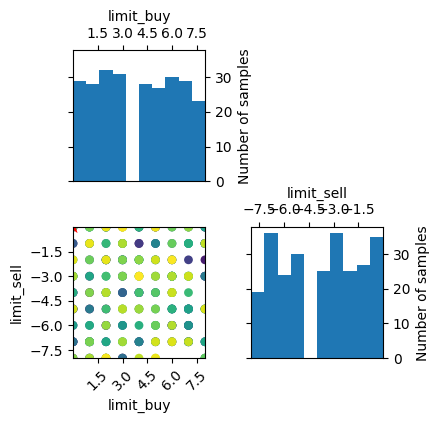

In [19]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

#### Density

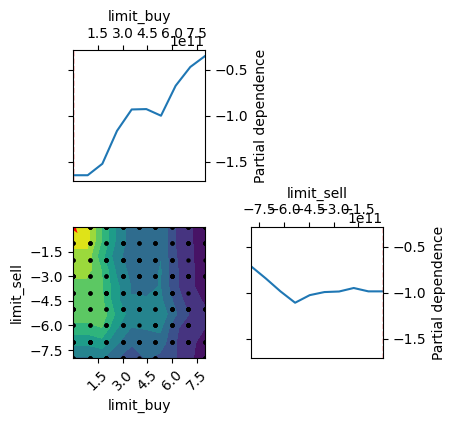

In [20]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

## How to solve the overfitting problem?

> Backtest the investment strategy on a validation set.

Next chapter → [The Overfitting Problem in Backtesting]()

![](<src/09_Table_The Overfitting.png>)